In [1]:
%matplotlib inline
import pandas as pd
import urllib as ur
import json
import datetime
import matplotlib.pyplot as plt

## Requisitando Bairros e seus respectivos estacionamentos e carros. 

In [2]:
# Request na api para pegar bairros, localizações e ids dos carros

#Formatando a request
response = ur.request.urlopen('https://bookit.modo.coop/api/fleet').read().decode('UTF-8')
json_Neighbourhood = json.loads(response)

response = ur.request.urlopen('https://bookit.modo.coop/api/fleet/locations').read().decode('UTF-8')
json_file = json.loads(response)

NeighbourhoodsIDs = list(json_Neighbourhood['Neighbourhoods'].keys())

location_id = []

for i in NeighbourhoodsIDs:
    for j in list(json_file['Neighbourhoods'][i]['Locations'].keys()):
        location_id.append([i,j])

# Dataframe com bairros e localizações
location_id = pd.DataFrame(location_id, columns=['neighbourhoods', 'locations'])

Cars = []
auxCar = []
IDs = []
auxLoc = []

for i in range(len(location_id)):
        neighbourhood = location_id['neighbourhoods'].iloc[i]
        loc = location_id['locations'].iloc[i]
        auxCar.append(list(json_file['Neighbourhoods'][neighbourhood]['Locations'][loc]['Cars']))
        
        # Percorre a lista com as IDs de localizações para pegar as multiplas ocorrências
        lista = list(json_file['Neighbourhoods'][neighbourhood]['Locations'][loc]['Cars'])
        for k in lista:
            auxLoc.append([neighbourhood, loc])

#Reformatando para uma lista unidimensional
for i in auxCar:    
    for j in i:
        Cars.append(j)

Cars = pd.DataFrame(Cars, dtype=int)
location_id = pd.DataFrame(auxLoc, dtype=int)
location_id = pd.concat([location_id, Cars], axis=1)
location_id.columns = ['neighbourhood', 'location', 'car_id']

# Ordenando o dataframe pelas localizações
location_id = location_id.sort_values(by=['location'])

In [3]:
# Filtrando os carros elétricos e híbridos

response = ur.request.urlopen('https://bookit.modo.coop/api/fleet/cars/fleet').read().decode('UTF-8')
json_cars = json.loads(response)

electric = []

for i in range(len(location_id)):
    neighbourhood = str(location_id['neighbourhood'].iloc[i])
    loc = str(location_id['location'].iloc[i])
    car = str(location_id['car_id'].iloc[i])
    
    try:
        accessories = list(json_cars['Neighbourhoods'][neighbourhood]['Locations'][loc]['Cars'][car]['Accessories'].values())
        if ('hybrid' in accessories):
            electric.append([int(car), 'hybrid'])
        if ('electric car' in accessories):
            electric.append([int(car), 'electric'])
    except:
        continue
    
    
electric = pd.DataFrame(electric, columns=['car_id', 'type'])

## Coletando a duração de cada viagem para carros normais, elétricos e híbridos.

In [4]:
# Lendo csv de intervalos de ociosidade e ocupação
dfOccupied = pd.read_csv('Occupied.csv', usecols=[1,2,3])
dfParked = pd.read_csv('ParkedN.csv', usecols=[1,2,3])

In [5]:
# Faz a diferença entre duas horas dadas e retorna em minutos
def Hour_Diff(h1,h2):
    h1Aux = datetime.datetime.fromtimestamp(h1)
    h2Aux = datetime.datetime.fromtimestamp(h2)
    diff = abs((h1Aux - h2Aux)).total_seconds()/60
    
    return diff

In [6]:
#  Fazendo a duração de cada intervalo de ocupação
diff = []
for i in range(len(dfOccupied)):
    diff.append(Hour_Diff(dfOccupied['start'].iloc[i], dfOccupied['end'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Occupied_Diff = pd.concat([dfOccupied, diff], axis=1)

In [7]:
# Fazendo a duração de cada intervalo de tempo de ociosidade
diff = []
for i in range(len(dfParked)):
    diff.append(Hour_Diff(dfParked['start'].iloc[i], dfParked['end'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Parked_Diff = pd.concat([dfParked, diff], axis=1)

In [8]:
# Filtra os intervalos de ocupação dos carros híbridos e elétricos

electric_occupied = []
hybrid_occupied = []

for i in range(len(electric)):
    occupied = Occupied_Diff[Occupied_Diff['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(occupied)):
            hybrid_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                   occupied['end'].iloc[j],occupied['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(occupied)):
            electric_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                     occupied['end'].iloc[j], occupied['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])

# Filtra o tempo de ociosidade dos carros híbridos e elétricos

electric_parked = []
hybrid_parked = []

for i in range(len(electric)):
    parked = Parked_Diff[Parked_Diff['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(parked)):
            hybrid_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                  parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(parked)):
            electric_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                    parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])
hybrid_parked = pd.DataFrame(hybrid_parked, columns=['car_id', 'start', 'end', 'duration'])
electric_parked = pd.DataFrame(electric_parked, columns=['car_id', 'start', 'end', 'duration'])

In [9]:
# Filtrando tempo de ocupação e tempo de ociosidade de carros normais
normal_cars_occupied = []

for i in range(len(Occupied_Diff)):
    if (Occupied_Diff['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_occupied.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                                    Occupied_Diff['end'].iloc[i], Occupied_Diff['duration'].iloc[i]])

normal_cars_occupied = pd.DataFrame(normal_cars_occupied, columns=['car_id', 'start', 'end', 'duration'])


normal_cars_parked = []

for i in range(len(Parked_Diff)):
    if (Parked_Diff['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_parked.append([Parked_Diff['car_id'].iloc[i], Parked_Diff['start'].iloc[i], 
                                    Parked_Diff['end'].iloc[i], Parked_Diff['duration'].iloc[i]])

normal_cars_parked = pd.DataFrame(normal_cars_parked, columns=['car_id', 'start', 'end', 'duration'])


## Plotagem dos CDFs.

In [10]:
# Função que retorna os valores do eixo x e y para uma cdf
# Deve receber os valores ordenados
def cdf(df):
    
    df = df.sort_values(by='duration')
    values = df['duration']
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

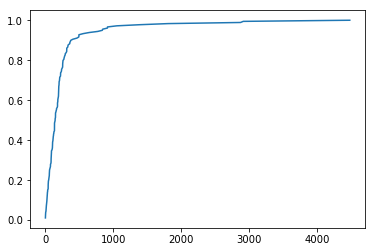

In [11]:
# CDF Ocupado de carros elétricos 
x, y = cdf(electric_occupied.sort_values(by='duration'))
plt.plot(x,y)

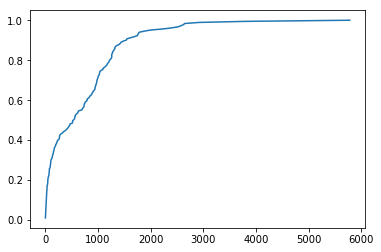

In [12]:
# CDF Ociosidade de carros elétricos
x, y = cdf(electric_parked.sort_values(by='duration'))
plt.plot(x,y)

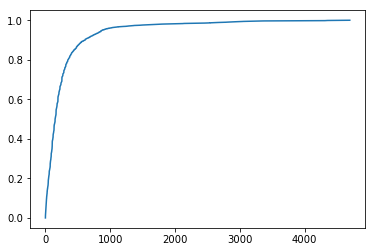

In [13]:
# CDF Ocupação de carros Híbridos
# 0.54% acima de 3 dias de duração retirados
x, y = cdf(hybrid_occupied.sort_values(by='duration')[:5178])
plt.plot(x,y)

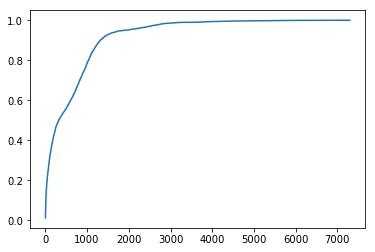

In [14]:
# CDF Ociosidade de carros Híbridos
# 0.03% acima de 5 dias e meio retirados
x, y = cdf(hybrid_parked.sort_values(by=['duration'])[:5316])
plt.plot(x,y)

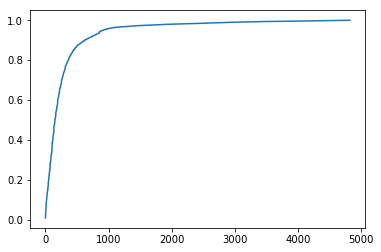

In [15]:
# CDF Ocupação de carros normais
# 0.56% acima de 3 dias retirados
x, y = cdf(normal_cars_occupied.sort_values(by=['duration'])[:19800])
plt.plot(x,y)

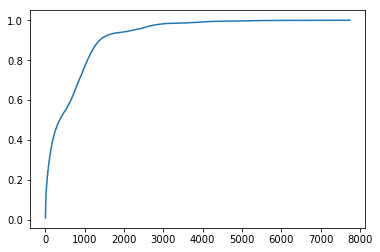

In [16]:
# CDF Viagens de carros normais
# 0.12% acima de 5 dias retirados
x, y = cdf(normal_cars_parked.sort_values(by='duration')[:20355])
plt.plot(x,y)

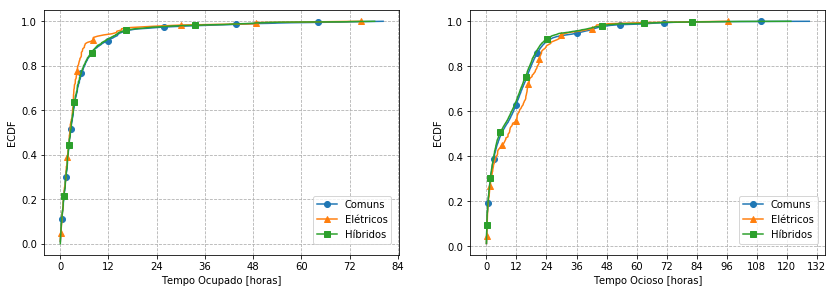

In [17]:
import numpy as np


fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(14,4.5)

# Plot do tempo ocupado

x, y = cdf(normal_cars_occupied.sort_values(by=['duration'])[:19800])
ax1.plot(x,y, label='Comuns', marker='o', markevery=[50, 300, 700, 1700, 3200, 4100, 4350, 4520])


x, y = cdf(electric_occupied.sort_values(by='duration'))
ax1.plot(x,y, label='Elétricos', marker='^', markevery=[5, 60, 120, 145, 157, 159, 160])


x, y = cdf(hybrid_occupied.sort_values(by='duration')[:5178])
ax1.plot(x,y, label='Híbridos', marker='s', markevery=[150, 440, 780, 1430, 1880, 2000])

ax1.grid(b=True, linestyle='--')

# Modificando os labels dos minutos
ax1.xaxis.set_ticks(np.arange(0, 5760, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,95,12)

ax1.set_xticklabels(labels)

ax1.legend(bbox_to_anchor=(0.75, 0.25), loc=2, borderaxespad=0.2)
ax1.set_ylabel('ECDF')
ax1.set_xlabel('Tempo Ocupado [horas]')


# Plot do tempo ocioso

x, y = cdf(normal_cars_parked.sort_values(by='duration')[:20355])
ax2.plot(x,y, label='Comuns', marker='o', markevery=[100, 700, 3200, 6000, 7500, 8220, 8400, 8510])

x, y = cdf(electric_parked.sort_values(by='duration'))
ax2.plot(x,y, label='Elétricos', marker='^', markevery=[5, 40, 70, 90, 120, 140, 160, 165, 171])

x, y = cdf(hybrid_parked.sort_values(by='duration')[:5316])
ax2.plot(x,y, label='Híbridos', marker='s', markevery=[20, 270, 900, 2000, 2800, 3100, 3160, 3190])

ax2.grid(b=True, linestyle='--')

# Modificando os labels dos minutos para horas
ax2.xaxis.set_ticks(np.arange(0, 8000, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0, 133, 12)

ax2.set_xticklabels(labels)

ax2.legend(bbox_to_anchor=(0.75, 0.25), loc=2, borderaxespad=0.2)
ax2.set_ylabel('ECDF')
ax2.set_xlabel('Tempo Ocioso [horas]')

plt.savefig('CDFs.pdf', bbox_inches='tight')

## Tarde e noite para dias de semana

In [18]:
tarde = []
noite = []

for i in range(len(Occupied_Diff)):
    start = Occupied_Diff['start'].iloc[i]
    hora = datetime.datetime.fromtimestamp(start).hour
    dia = int(datetime.datetime.fromtimestamp(start).strftime('%w'))
    if ((hora >= 11 and hora <= 13) and (dia > 0  and dia < 6)):
        tarde.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])
    elif ((hora >= 18 and hora <= 19) and (dia > 0  and dia < 6)):
        noite.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])

tarde = pd.DataFrame(tarde, columns=['car_id', 'start', 'duration'])
noite = pd.DataFrame(noite, columns=['car_id', 'start', 'duration'])

In [19]:
# Durações menores que 66 horas
tarde = tarde[tarde['duration'] < 4000]
noite = noite[noite['duration'] < 4000]

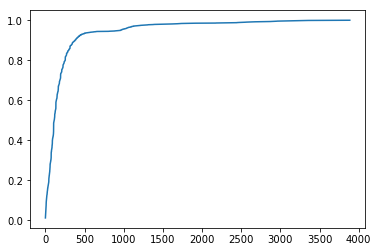

In [20]:
x, y = cdf(tarde.sort_values(by='duration'))
plt.plot(x,y)

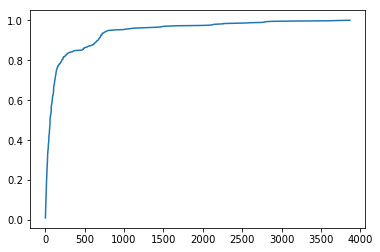

In [21]:
x, y = cdf(noite.sort_values(by='duration'))
plt.plot(x,y)

In [22]:
# Durações menores ou iguais que 28 horas
tarde = tarde[tarde['duration'] <= 28*60]
noite = noite[noite['duration'] <= 28*60]
todos = Occupied_Diff[Occupied_Diff['duration'] <= 28*60]

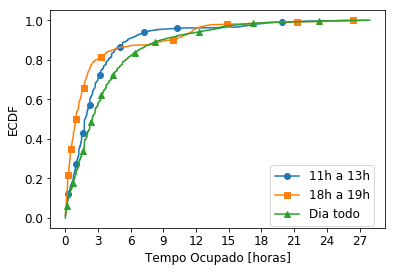

In [23]:
import matplotlib

matplotlib.rc('font', size=12)

fig, ax = plt.subplots()

x, y = cdf(tarde.sort_values(by='duration'))
ax.plot(x,y, label='11h a 13h', marker='o', markevery=[30,140,280,400,580,800,960,1010,1100])

x, y = cdf(noite.sort_values(by='duration'))
ax.plot(x,y, label='18h a 19h', marker='s', markevery=[30,60,120,190,280,340,392,400,406])

x, y = cdf(todos.sort_values(by='duration'))
ax.plot(x,y, label='Dia todo', marker='^', markevery=[20,120,350,600,960,1400,2200,2800,3600,4300,4550])

# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 1800, 180))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,30,3)

ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(0.65, 0.3), loc=2, borderaxespad=0.2)
ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo Ocupado [horas]')

plt.savefig('tarde_noiteCDF.pdf')